Data from https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis.

lunch basic mlflow server with 

mlflow server --host 127.0.0.1 --port 8080   

In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import re
from tqdm import tqdm

/opt/anaconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('twitter_training.csv', header=None)
df.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_content']
df.head() 

,tweet_id,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


check column names and datatypes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet_id       74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


check for nulls

In [4]:
df.isnull().any()

tweet_id         False
entity           False
sentiment        False
tweet_content     True
dtype: bool

fill empty tweet_content with ''

In [5]:
df['tweet_content'] = df['tweet_content'].fillna('')
df.isnull().any()

tweet_id         False
entity           False
sentiment        False
tweet_content    False
dtype: bool

Check nunique for categorical features to figure out appropriate encoding. The entity column can be one-hot encoded or ordinal encoded. However, tweet_content requires a more sophisticated encoder.

In [8]:
df.select_dtypes('object').nunique()

entity              32
sentiment            4
tweet_content    69492
dtype: int64

# EDA

The sentiments are well represented per category.

<Axes: ylabel='sentiment'>

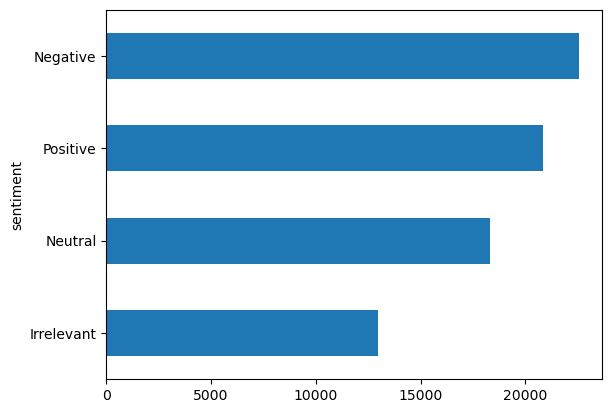

In [15]:
df.sentiment.value_counts().sort_values().plot(kind='barh')

Try to figure out most common words from tweet content.  
The top 20 most common words are not useful for predicting sentiment. However, we can use tfidf vectorizer to solve this problem.

In [16]:

def clean_content(content):
    words = list(set(content.split(' ')))
    cleaned_words = [re.sub(r'\W+', '', word) for word in words if re.sub(r'\W+', '', word)]
    return cleaned_words

cleaned_content = df.tweet_content.apply(clean_content)

unique_words = set()
for word_list in tqdm(cleaned_content):
    unique_words = unique_words.union(set(word_list))

word_count = dict()
for word in list(unique_words):
    word_count[word] = 0

for word_list in cleaned_content:
    for word in word_list:
        word_count[word] += 1

word_count_list = word_count.items()
sorted(word_count_list, key=lambda x: x[1], reverse=True)[:20]

100%|██████████| 74682/74682 [01:13<00:00, 1021.46it/s]


[('the', 25733),
 ('to', 20702),
 ('and', 19029),
 ('I', 18021),
 ('a', 17151),
 ('of', 15279),
 ('is', 14600),
 ('for', 12798),
 ('in', 12560),
 ('it', 10363),
 ('this', 10320),
 ('on', 10221),
 ('my', 8657),
 ('that', 8450),
 ('you', 8309),
 ('with', 7707),
 ('game', 6687),
 ('me', 5931),
 ('so', 5611),
 ('have', 5502)]

# Training

In [17]:
X = df.drop('sentiment', axis=1)
y = df['sentiment'].to_frame()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

sample_row = X.iloc[0, :].to_dict()

Remove none alphanumeric characters

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class CleanContentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X, y=None):
        # Apply the clean_content function to each entry in the DataFrame column
        return X.apply(self.clean_content)

    @staticmethod
    def clean_content(content):
        words = list(set(content.split(' ')))
        cleaned_words = [re.sub(r'\W+', '', word) for word in words if re.sub(r'\W+', '', word)]
        joined_words = ' '.join(cleaned_words)
        return joined_words

In [19]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)
lgbm_clf = LGBMClassifier()
tfidf_pipeline = Pipeline(steps=[
    ('clean', CleanContentTransformer()),
    ('tfidf', TfidfVectorizer()),
    ('model', lgbm_clf)
])

# joined_words = [' '.join(word_list) for word_list in cleaned_content]

tfidf_pipeline.fit(X_train['tweet_content'], y_train_encoded)
preds = tfidf_pipeline.predict(X_valid['tweet_content'])

acc = accuracy_score(y_valid_encoded, preds)
print(f'accuracy_score: {acc}')

# tfidf = TfidfVectorizer()
# train_matrix = tfidf.fit_transform(joined_words)



/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.200448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152735
[LightGBM] [Info] Number of data points in the train set: 52277, number of used features: 3608
[LightGBM] [Info] Start training from score -1.745100
[LightGBM] [Info] Start training from score -1.195724
[LightGBM] [Info] Start training from score -1.403758
[LightGBM] [Info] Start training from score -1.282960
accuracy_score: 0.6481142602097746


Display confusion matrix

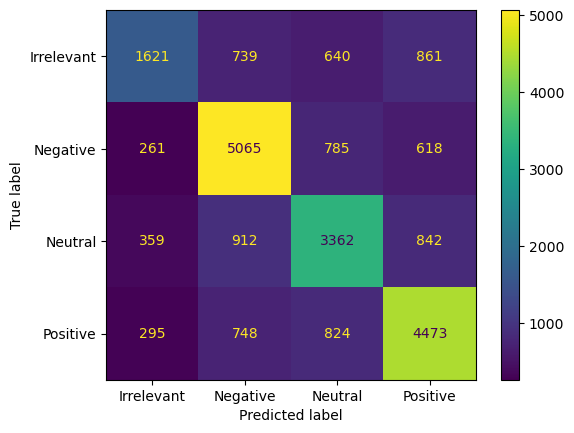

In [12]:
def display_cm(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()

display_cm(y_valid_encoded, preds)

Function to evaluate performance of different classifiers.  
RandomForestClassifier has a significantly higher accuracy than lgbm and xgboost.

In [13]:
def eval_clf(classifier):
    tfidf_pipeline = Pipeline(steps=[
        ('clean', CleanContentTransformer()),
        ('tfidf', TfidfVectorizer()),
        ('model', classifier)
    ])
    tfidf_pipeline.fit(X_train['tweet_content'], y_train_encoded)
    preds = tfidf_pipeline.predict(X_valid['tweet_content'])

    return accuracy_score(y_valid_encoded, preds)

xgb_clf = XGBClassifier()
rf_clf = RandomForestClassifier()

for clf in tqdm([lgbm_clf, xgb_clf, rf_clf]):
    print(f'accuracy_score: {eval_clf(clf)}')
 



  0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.394268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152735
[LightGBM] [Info] Number of data points in the train set: 52277, number of used features: 3608
[LightGBM] [Info] Start training from score -1.745100
[LightGBM] [Info] Start training from score -1.195724
[LightGBM] [Info] Start training from score -1.403758
[LightGBM] [Info] Start training from score -1.282960


 33%|███▎      | 1/3 [00:15<00:30, 15.16s/it]

accuracy_score: 0.6481142602097746


 67%|██████▋   | 2/3 [01:14<00:41, 41.39s/it]

accuracy_score: 0.6500781075652756


100%|██████████| 3/3 [03:49<00:00, 76.47s/it]

accuracy_score: 0.8883731309975452


# Optuna for LGBMClassifier
Choose a better n_estimator for lgbm to improve accuracy. At around 483 n_estimators, the model already achieved a significantly higher accuracy at 83%. Succeeding trials with more n_estimators did not significantly improve this accuracy. 

In [18]:
def objective(trial):
    # learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 20, 4000)
    classifier = LGBMClassifier(n_estimators=n_estimators)
    # classifier = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate)
    tfidf_pipeline = Pipeline(steps=[
        ('clean', CleanContentTransformer()),
        ('tfidf', TfidfVectorizer()),
        ('model', classifier)
    ])
    tfidf_pipeline.fit(X_train['tweet_content'], y_train_encoded)
    return tfidf_pipeline.score(X_valid['tweet_content'], y_valid_encoded )

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)
    

[I 2024-10-23 08:44:56,865] A new study created in memory with name: no-name-65b25a06-3b65-48b8-bfc3-ee217e63fea5


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.221555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152735
[LightGBM] [Info] Number of data points in the train set: 52277, number of used features: 3608
[LightGBM] [Info] Start training from score -1.745100
[LightGBM] [Info] Start training from score -1.195724
[LightGBM] [Info] Start training from score -1.403758
[LightGBM] [Info] Start training from score -1.282960


[I 2024-10-23 08:48:12,631] Trial 0 finished with value: 0.8315554563713456 and parameters: {'n_estimators': 1941}. Best is trial 0 with value: 0.8315554563713456.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.465600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 152735
[LightGBM] [Info] Number of data points in the train set: 52277, number of used features: 3608
[LightGBM] [Info] Start training from score -1.745100
[LightGBM] [Info] Start training from score -1.195724
[LightGBM] [Info] Start training from score -1.403758
[LightGBM] [Info] Start training from score -1.282960


[I 2024-10-23 08:49:08,891] Trial 1 finished with value: 0.7715688462396787 and parameters: {'n_estimators': 489}. Best is trial 0 with value: 0.8315554563713456.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.411084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152735
[LightGBM] [Info] Number of data points in the train set: 52277, number of used features: 3608
[LightGBM] [Info] Start training from score -1.745100
[LightGBM] [Info] Start training from score -1.195724
[LightGBM] [Info] Start training from score -1.403758
[LightGBM] [Info] Start training from score -1.282960


[I 2024-10-23 08:50:15,487] Trial 2 finished with value: 0.7869671948225843 and parameters: {'n_estimators': 624}. Best is trial 0 with value: 0.8315554563713456.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.288591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152735
[LightGBM] [Info] Number of data points in the train set: 52277, number of used features: 3608
[LightGBM] [Info] Start training from score -1.745100
[LightGBM] [Info] Start training from score -1.195724
[LightGBM] [Info] Start training from score -1.403758
[LightGBM] [Info] Start training from score -1.282960


[I 2024-10-23 08:53:40,638] Trial 3 finished with value: 0.8351707208212452 and parameters: {'n_estimators': 2328}. Best is trial 3 with value: 0.8351707208212452.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.392739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152735
[LightGBM] [Info] Number of data points in the train set: 52277, number of used features: 3608
[LightGBM] [Info] Start training from score -1.745100
[LightGBM] [Info] Start training from score -1.195724
[LightGBM] [Info] Start training from score -1.403758
[LightGBM] [Info] Start training from score -1.282960


[I 2024-10-23 08:55:33,532] Trial 4 finished with value: 0.8163356393662129 and parameters: {'n_estimators': 1063}. Best is trial 3 with value: 0.8351707208212452.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.513085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 152735
[LightGBM] [Info] Number of data points in the train set: 52277, number of used features: 3608
[LightGBM] [Info] Start training from score -1.745100
[LightGBM] [Info] Start training from score -1.195724
[LightGBM] [Info] Start training from score -1.403758
[LightGBM] [Info] Start training from score -1.282960


[I 2024-10-23 09:01:14,429] Trial 5 finished with value: 0.8393662128989064 and parameters: {'n_estimators': 3168}. Best is trial 5 with value: 0.8393662128989064.


# Optuna for XGBClassifier
Choose a better n_estimator for xgb to improve accuracy. At around 1596 n_estimators, the model already achieved a significantly higher accuracy at 83%. Succeeding trials with more n_estimators did not significantly improve this accuracy. 

In [19]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 2000)
    classifier = XGBClassifier(n_estimators=n_estimators)
    tfidf_pipeline = Pipeline(steps=[
        ('clean', CleanContentTransformer()),
        ('tfidf', TfidfVectorizer()),
        ('clf', classifier)
    ])

    tfidf_pipeline.fit(X_train['tweet_content'], y_train_encoded)
    return tfidf_pipeline.score(X_valid['tweet_content'], y_valid_encoded)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)

[I 2024-10-23 10:16:22,831] A new study created in memory with name: no-name-b92f92f1-f787-4f99-bdb6-989dfff59cf5
[I 2024-10-23 10:19:11,334] Trial 0 finished with value: 0.7453693372015175 and parameters: {'n_estimators': 381}. Best is trial 0 with value: 0.7453693372015175.
[I 2024-10-23 10:29:24,201] Trial 1 finished with value: 0.8316893550546753 and parameters: {'n_estimators': 1658}. Best is trial 1 with value: 0.8316893550546753.
[I 2024-10-23 10:39:13,888] Trial 2 finished with value: 0.8311983932158 and parameters: {'n_estimators': 1596}. Best is trial 1 with value: 0.8316893550546753.
[I 2024-10-23 10:41:43,829] Trial 3 finished with value: 0.7293461280964071 and parameters: {'n_estimators': 300}. Best is trial 1 with value: 0.8316893550546753.


# Optuna for RandomForrest
Choose a better n_estimator for RandomForest to improve accuracy. At around 500 n_estimators, the model already achieved 89% accuracy. Succeeding trials with more n_estimators did not significantly improve this accuracy. 

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 2000)
    classifier = RandomForestClassifier(n_estimators=n_estimators)
    tfidf_pipeline = Pipeline(steps=[
        ('clean', CleanContentTransformer()),
        ('tfidf', TfidfVectorizer()),
        ('clf', classifier)
    ])

    tfidf_pipeline.fit(X_train['tweet_content'], y_train_encoded)
    return tfidf_pipeline.score(X_valid['tweet_content'], y_valid_encoded)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)

# K-MEANS clustering
k-means scored the lowest accuracy at 24%

In [44]:
km_clf = KMeans(n_clusters=4, max_iter=1000)
tfidf_pipeline = Pipeline(steps=[
    ('clean', CleanContentTransformer()),
    ('tfidf', TfidfVectorizer()),
    ('clf', km_clf)
])

tfidf_pipeline.fit(X_train['tweet_content'])
preds = tfidf_pipeline.predict(X_valid['tweet_content'])
acc = accuracy_score(y_valid_encoded, preds)

print(f'accuracy_score: {acc}')
print(classification_report(y_valid_encoded, preds))

accuracy_score: 0.30046864539165363
              precision    recall  f1-score   support

           0       0.21      0.13      0.16      3861
           1       0.35      0.31      0.33      6729
           2       0.30      0.49      0.37      5475
           3       0.28      0.23      0.25      6340

    accuracy                           0.30     22405
   macro avg       0.29      0.29      0.28     22405
weighted avg       0.30      0.30      0.29     22405



# Word2Vec
Use word2vec instead of tfidf

In [21]:
from gensim.models import Word2Vec

# tfidf_pipeline = Pipeline(steps=[
#     ('clean', CleanContentTransformer()),
#     ('tfidf', TfidfVectorizer()),
#     ('clf', km_clf)
# ])

cc = CleanContentTransformer()

words = cc.fit_transform(X_train['tweet_content'])
words

61528    show tv DAHYE NOW it vid x for used my his on ...
66245    Johnson baby powder would US denying pleasecom...
32930    have bitch endt i for two a pressed in better ...
55449     Absolutely CallofDuty 156GB pathetic over gotten
48420    dont right displays calling to furniture their...
                               ...                        
21243    Help this 2015GO me wnnrEp9n6T free win from I...
45891    Facebook on platform rampant faces and fall Th...
42613    dont into 10 know was lot my logged for my ID ...
43567    video finished my last v enjoy 2nd a and in th...
68268    have it be with still wont this Johnny about C...
Name: tweet_content, Length: 52277, dtype: object

# NN with embedding layer